TensorFlow v 2.9.1
Mode: CPU
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Strategy is <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x0000022DC8DCFE20>.
Scope: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x0000022DC8DCFE20>
Учим сеть...
Epoch 1/30
3000/3000 [==============================] - 13s 4ms/step - loss: 0.0525 - accuracy: 0.9768
Epoch 2/30
3000/3000 [==============================] - 11s 4ms/step - loss: 0.0095 - accuracy: 0.9998
Epoch 3/30
3000/3000 [==============================] - 11s 4ms/step - loss: 0.0047 - accuracy: 0.9997
Epoch 4/30
3000/3000 [==============================] - 11s 4ms/step - loss: 0.0031 - accuracy: 0.9997
Epoch 5/30
3000/3000 [==============================] - 11s 4ms/step - loss: 0.0023 - accuracy: 0.9997
Epoch 6/30
3000/3000 [==============================] - 9s 3ms/step - loss: 0.0019 - accuracy: 0.9998
Epoch 7/30
3000/3000 [=======

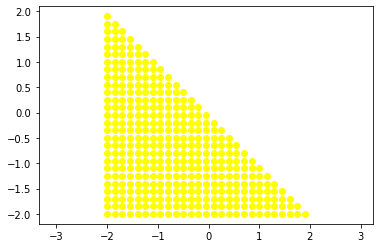

In [5]:
import os
import math
import numpy as np

import tensorflow as tf
import tensorflow
from keras.models import Model
from keras.layers import Dense, Input

import logging

import matplotlib.pyplot as plt

# много непонятных букв, будем делать искусство
logging.getLogger('tensorflow').setLevel(logging.WARNING)

# tf.enable_eager_execution()

print("TensorFlow v", tf.version.VERSION)

# input data

np.random.seed(1)
A = (np.random.random((3000, 2)) * 4.0 - 2.0).astype(np.float32)
V = [np.float32((x*math.cos(math.pi/4) + y*math.sin(math.pi/4)) <= 0) for (x, y) in A]

if len(tensorflow.test.gpu_device_name()):  # GPU
    mode = 'GPU'
else:
    mode = 'CPU'

print("Mode:", mode)
# mode = 'CPU'

logging.getLogger('tensorflow').setLevel(logging.INFO)
if mode == 'GPU':
    strategy = tensorflow.distribute.MirroredStrategy(
        devices=[tensorflow.test.gpu_device_name()]
    )
elif mode == 'TPU':
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    tf.config.experimental_connect_to_host(resolver.master())
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.experimental.TPUStrategy(resolver)
else:  # mode == 'CPU'
    strategy = tensorflow.distribute.MirroredStrategy(devices=['CPU'])

logging.getLogger('tensorflow').setLevel(logging.WARNING)
print(f"Strategy is {strategy}.")

with strategy.scope() as scope:
    model = tf.keras.Sequential([
        Input(2),
        Dense(18, activation='sigmoid', use_bias=True),
        Dense(1, activation='sigmoid', use_bias=False)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.mean_squared_error,
        metrics='accuracy'
    )
    print("Scope:", scope)

dataset = tf.data.Dataset.from_tensor_slices((
    tf.constant(A, dtype=tf.float32),
    tf.constant(V, dtype=tf.float32)
)).shuffle(len(A) * 2, reshuffle_each_iteration=True).batch(1000).repeat()

if os.path.isfile("smart_colab_duckling.h5"):
    model.load_weights("smart_colab_duckling.h5")
    print("Сеть уже была научена раньше.")
else:
    print("Учим сеть...")
    model.fit(
        dataset,
        epochs=30,
        steps_per_epoch=3000
        )

plt.axis('equal')

c = np.r_[-2:2:0.15]

XY = np.transpose([np.tile(c, len(c)), np.repeat(c, len(c))])

Z = model.predict(XY)

for (x, y), z in zip(XY, Z):
    plt.scatter(x, y, c='yellow' if z > 0.5 else 'white')

plt.show()